In [4]:
!pip3 install mnist
!pip3 install minisom

# imports
import matplotlib.pyplot as plt
import numpy as np
import mnist
import scipy.misc
import math

from sklearn import datasets,metrics
from sklearn.datasets import fetch_20newsgroups_vectorized, fetch_rcv1

from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
import umap
from minisom import MiniSom  


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering


!pip install ipython-autotime
%load_ext autotime

time: 225 µs (started: 2021-01-09 03:04:45 +00:00)


In [5]:
# Load Digits dataset
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
data = digits.images.reshape((digits_n_samples, -1))
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=True)
print(digits_n_samples)


# Load full MNIST dataset
MNIST_X_train = mnist.train_images()
MNIST_X_train = MNIST_X_train.reshape((len(MNIST_X_train), -1)) 
MNIST_y_train = mnist.train_labels()

MNIST_X_test = mnist.test_images()
MNIST_X_test = MNIST_X_test.reshape((len(MNIST_X_test), -1)) 
MNIST_y_test = mnist.test_labels()

total_samples = len(MNIST_X_train) + len(MNIST_X_test)
print(total_samples)
blob_test_size = len(MNIST_X_test)/total_samples

# Load generated blobs dataset
blobs_X, blobs_y = datasets.make_blobs(n_samples=total_samples, centers=10, n_features=MNIST_X_train.shape[1], random_state=0)
blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test = train_test_split(blobs_X, blobs_y, test_size=blob_test_size, shuffle=True)

# Keep number of training samples consistent
assert (len(blobs_X_train) == len(MNIST_X_train)), print(len(blobs_X_train), len(MNIST_X_train))
assert (len(blobs_X_test) == len(MNIST_X_test)), print(len(blobs_X_test), len(MNIST_X_test))



#Load the 20NewsGroups
newsgroups_train = fetch_20newsgroups_vectorized(subset='train', remove = ('headers', 'footers', 'quotes'))
newsgroups_X_train = newsgroups_train.data
newsgroups_y_train = newsgroups_train.target

newsgroups_test = fetch_20newsgroups_vectorized(subset='test', remove = ('headers', 'footers', 'quotes'))
newsgroups_X_test = newsgroups_test.data
newsgroups_y_test = newsgroups_test.target


#Load the RCV dataset
rcv1_train = fetch_rcv1(subset='train')
rcv1_X_train = newsgroups_train.data
rcv1_y_train = newsgroups_train.target

rcv1_test = fetch_rcv1(subset='test')
rcv1_X_test = newsgroups_test.data
rcv1_y_test = newsgroups_test.target




1797
70000
time: 22.7 s (started: 2021-01-09 03:04:45 +00:00)


In [6]:
# k-Means clustering
def kmeans(X_train, X_test, y_train, y_test, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=0)
  y_pred_train = kmeans.fit_predict(X_train)
  train_centers = kmeans.cluster_centers_

  y_pred_test = kmeans.fit_predict(X_test)
  test_centers = kmeans.cluster_centers_

  return y_pred_train, y_pred_test, train_centers, test_centers
  

time: 8.46 ms (started: 2021-01-09 03:05:08 +00:00)


In [7]:
# Spectral clustering 
def spectral(X_train, X_test, y_train, y_test, n_clusters):
  spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
  y_pred_train = spectral.fit_predict(X_train)
  y_pred_test = spectral.fit_predict(X_test)

  return y_pred_train, y_pred_test


time: 2.42 ms (started: 2021-01-09 03:05:08 +00:00)


In [8]:
# Evaluation function
def evaluate(X, y, y_pred):
    print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Adjusted Rand Index Score: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Normalized Mutual Information Score: %0.3f" % metrics.normalized_mutual_info_score(y, y_pred))

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))

    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred, sample_size=1000))
    print()



time: 14.7 ms (started: 2021-01-09 03:05:08 +00:00)


In [9]:
# dimension reduction


def pca_reduce(X_train, X_test, dim):
  pca = None
  if scipy.sparse.issparse(X_train):
    pca = TruncatedSVD(n_components=dim)
  else:
    pca = PCA(n_components=dim)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)

  return X_train_pca, X_test_pca


def tsne_reduce(X_train, X_test, dim):
  tsne = TSNE(n_components= dim)
  X_train_tsne = tsne.fit_transform(X_train)
  X_test_tsne = tsne.fit_transform(X_test)

  return X_train_tsne, X_test_tsne

def umap_reduce(X_train, X_test, dim):
  umapr = umap.UMAP(n_components=dim)
  X_train_umap = umapr.fit_transform(X_train)
  X_test_umap = umapr.fit_transform(X_test)
  return X_train_umap, X_test_umap


def kernel_pca_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='rbf')
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)

  return X_train_kpca, X_test_kpca

def som_reduce(X_train, X_test, dim):

  grid_size_train = math.ceil(np.sqrt(len(X_train))) 
  som = MiniSom(grid_size_train, grid_size_train, X_train.shape[1])
  som.pca_weights_init(X_train)
  som.train(X_train, 5000, random_order=True, verbose=True)

  X_train_som = np.array([som.winner(x) for x in X_train])


  grid_size_test = math.ceil(np.sqrt(len(X_test)))
  som = MiniSom(grid_size_test, grid_size_test, X_train.shape[1])
  som.pca_weights_init(X_test)
  som.train(X_test, 5000, random_order=True, verbose=True)

  X_test_som = np.array([som.winner(x) for x in X_test]) 



  return X_train_som, X_test_som






def dimension_reduce(dimensions, X_train, X_test, y_train, y_test, reduce, n_clusters):
  y_pred_train, y_pred_test, _, _ = kmeans(X_train, X_test, y_train, y_test, n_clusters)
  print("Original KMeans")
  evaluate(X_train,y_train,y_pred_train) 

  y_pred_train, y_pred_test = spectral(X_train, X_test, y_train, y_test, n_clusters)
  print("Original Spectral")
  evaluate(X_train,y_train,y_pred_train) 
  
  
  for dim in dimensions:
    #PCA reduction
    X_train_pca, X_test_pca = reduce(X_train, X_test, dim)

    y_pred_train, y_pred_test, _, _ = kmeans(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("KMeans dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)

    y_pred_train, y_pred_test= spectral(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("Spectral dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)







time: 88 ms (started: 2021-01-09 03:05:08 +00:00)


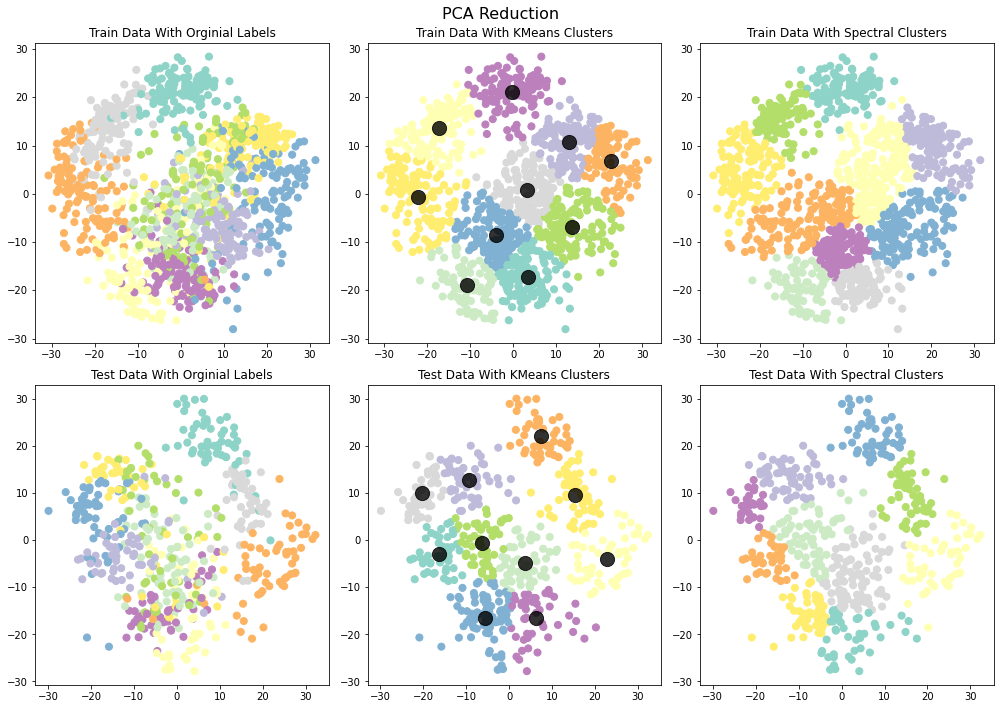

time: 2.1 s (started: 2021-01-09 03:05:09 +00:00)


In [10]:
# Visualization general

def visualize(X_train, X_test, y_train, y_test, reduce, title, n_clusters):

  X_train_r, X_test_r = reduce(X_train, X_test, 2)


  kmy_pred_train, kmy_pred_test, train_centers, test_centers = kmeans(X_train_r, X_test_r, y_train, y_test, n_clusters)
  spy_pred_train, spy_pred_test = spectral(X_train_r, X_test_r, y_train, y_test, n_clusters)

  
  fig=plt.figure(figsize=(14,10))
  # Train orginial labels
  plt.subplot(2, 3, 1)
  plt.gca().set_title('Train Data With Orginial Labels')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= y_train, s=50, cmap='Set3')

  # Train kmeans labels
  plt.subplot(2, 3, 2)
  plt.gca().set_title('Train Data With KMeans Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= kmy_pred_train, s=50, cmap='Set3')
  plt.scatter(train_centers [:, 0], train_centers [:, 1], c='black', s=200, alpha=0.8)

  # Train spectral labels
  plt.subplot(2, 3, 3)
  plt.gca().set_title('Train Data With Spectral Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= spy_pred_train, s=50, cmap='Set3')


  # Test orginial labels
  plt.subplot(2, 3, 4)
  plt.gca().set_title('Test Data With Orginial Labels')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= y_test, s=50, cmap='Set3')

  # Test kmeans labels
  plt.subplot(2, 3, 5)
  plt.gca().set_title('Test Data With KMeans Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= kmy_pred_test, s=50, cmap='Set3')
  plt.scatter(test_centers[:, 0], test_centers[:, 1], c='black', s=200, alpha=0.8)

  # Test spectral labels
  plt.subplot(2, 3, 6)
  plt.gca().set_title('Test Data With Spectral Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= spy_pred_test, s=50, cmap='Set3')

  fig.suptitle(title + " Reduction", fontsize=16)

  fig.tight_layout()
  fig.subplots_adjust(top=0.93)
  plt.show()



visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, pca_reduce, "PCA", 10)


 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 15.88372087821968
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 14.013049172601644


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


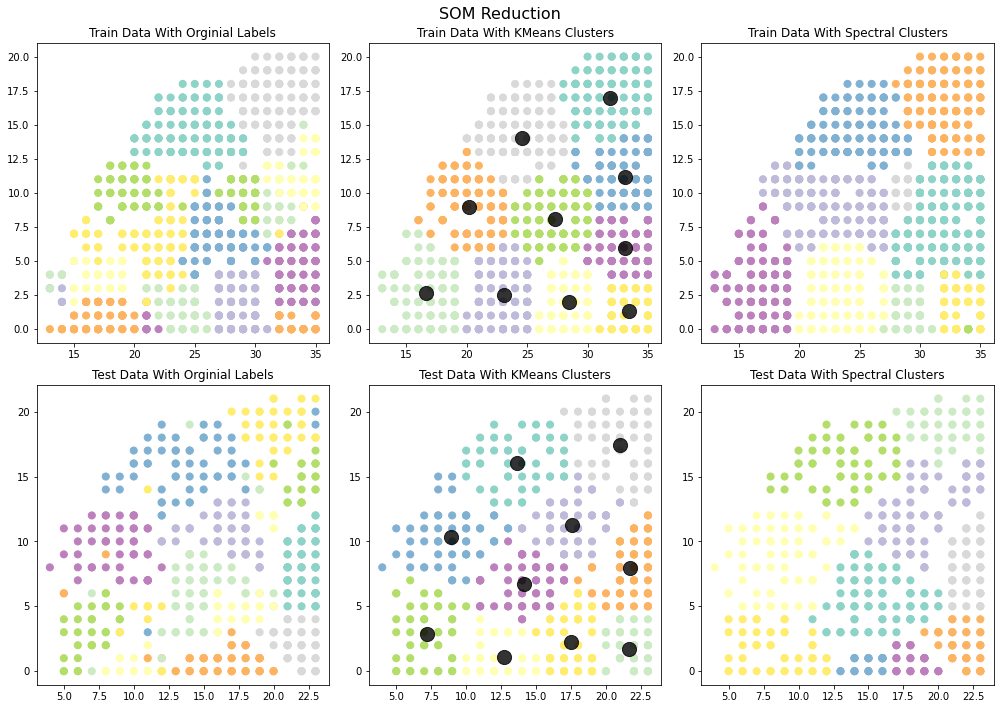

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


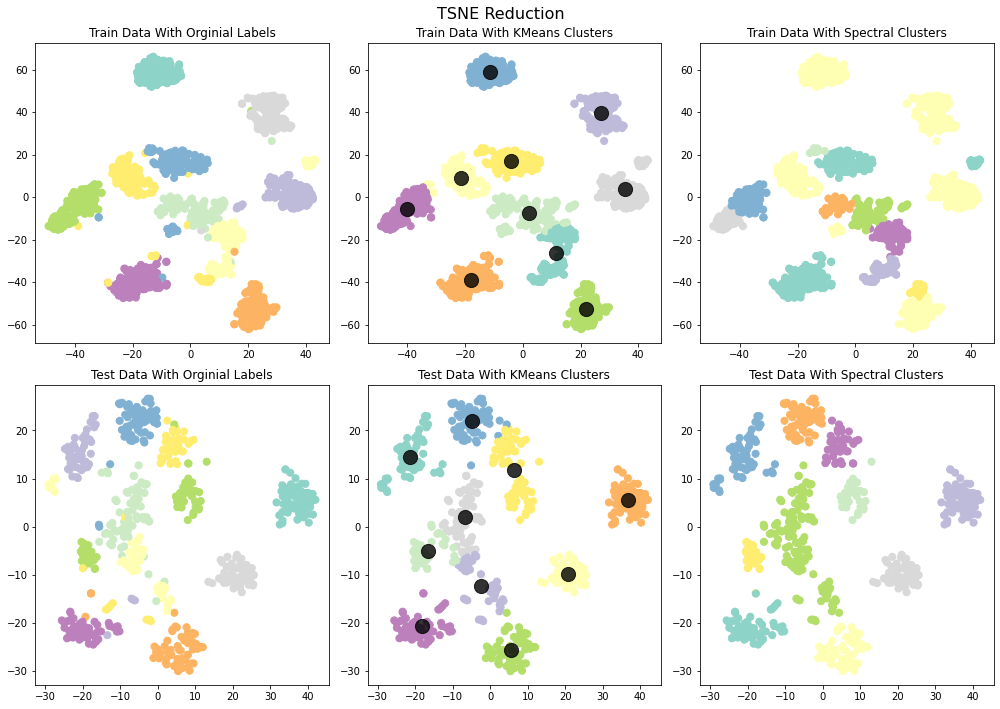

time: 25.2 s (started: 2021-01-09 03:05:19 +00:00)


In [11]:
# Digits reduction 
#dimension_reduce([48, 32, 16, 8, 4, 2], digits_X_train, digits_X_test, digits_y_train, digits_y_test, umap_reduce, 10)
visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, som_reduce, "SOM", 10)

visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, tsne_reduce, "TSNE", 10)

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


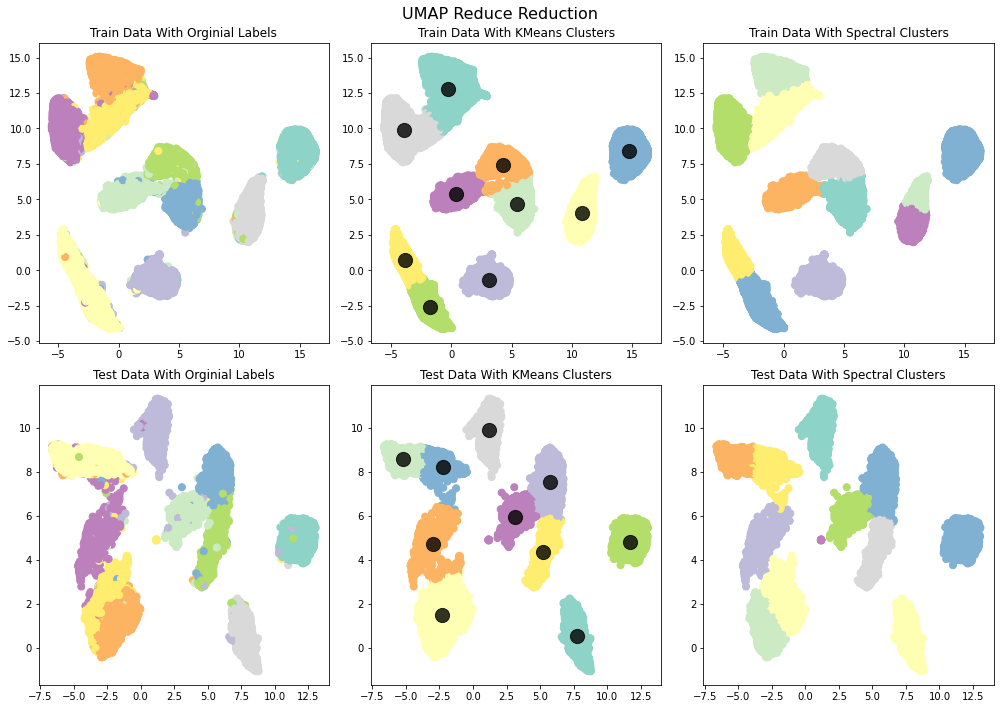

 [ 5000 / 5000 ] 100% - 0:00:01 left 

In [ ]:
# MNIST reduction 

#dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,umap_reduce, 10)
#dimension_reduce([2], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,som_reduce, 10)
visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, umap_reduce, "UMAP Reduce", 10)
visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, som_reduce, "SOM Reduce", 10)



In [ ]:
# blobs reduction 
dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50, 4], blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test, 10)
#visualize_pca(blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test, 10)
#visualize_tsne(blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test, 10)

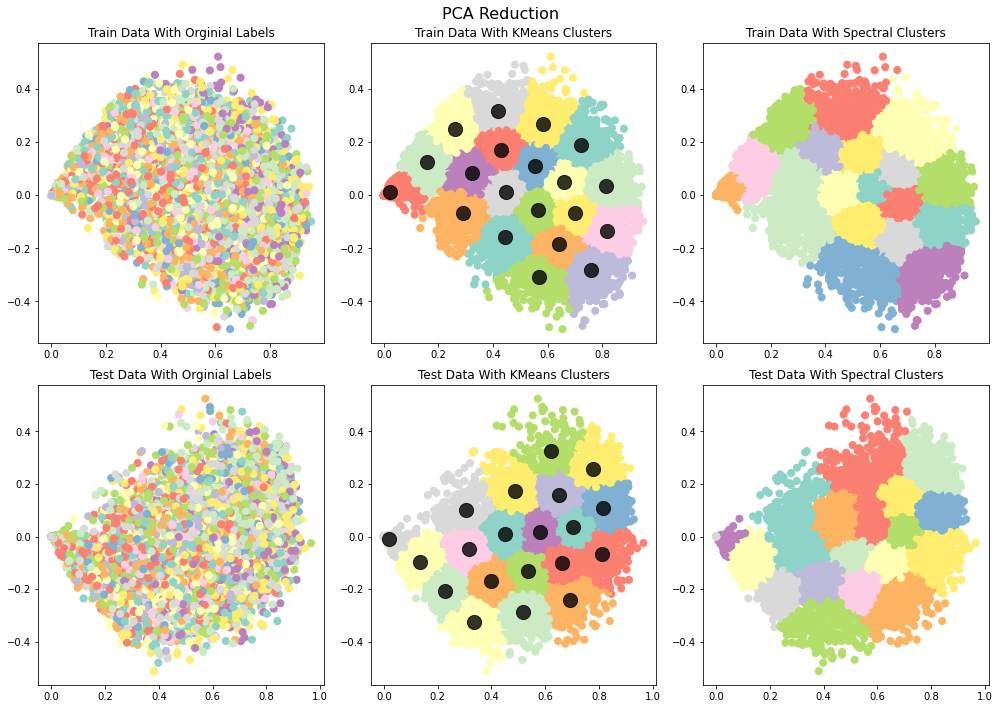

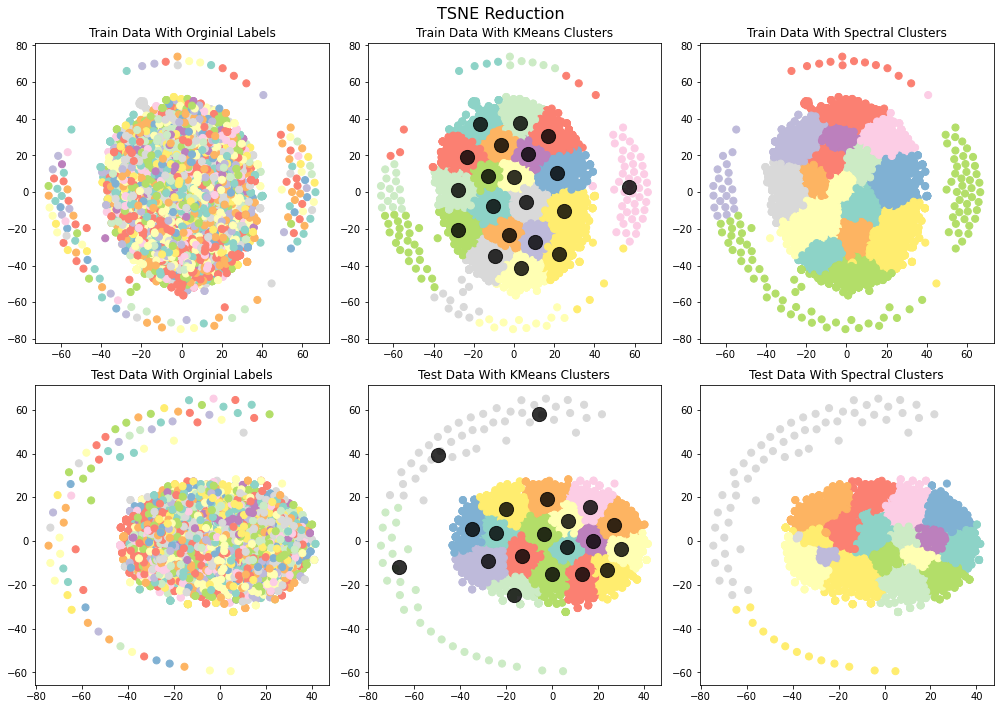

time: 14min 39s (started: 2021-01-08 01:13:18 +00:00)


In [ ]:
# fetch 20 reduction 
#dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train , newsgroups_y_test, 20)
visualize_pca(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train , newsgroups_y_test, 20)
visualize_tsne(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train , newsgroups_y_test, 20, True)

Original KMeans
Adjusted Mutual Information Score: 0.071
Adjusted Rand Index Score: 0.018
Normalized Mutual Information Score: 0.089
Homogeneity: 0.102
Completeness: 0.079
V-measure: 0.089
Silhouette Coefficient: -0.032

KMeans PCA dimension reduce: 1000
Adjusted Mutual Information Score: 0.078
Adjusted Rand Index Score: 0.016
Normalized Mutual Information Score: 0.100
Homogeneity: 0.122
Completeness: 0.084
V-measure: 0.100
Silhouette Coefficient: -0.037

KMeans PCA dimension reduce: 500
Adjusted Mutual Information Score: 0.075
Adjusted Rand Index Score: 0.016
Normalized Mutual Information Score: 0.097
Homogeneity: 0.120
Completeness: 0.081
V-measure: 0.097
Silhouette Coefficient: -0.029

KMeans PCA dimension reduce: 300
Adjusted Mutual Information Score: 0.078
Adjusted Rand Index Score: 0.015
Normalized Mutual Information Score: 0.100
Homogeneity: 0.125
Completeness: 0.084
V-measure: 0.100
Silhouette Coefficient: -0.023

KMeans PCA dimension reduce: 200
Adjusted Mutual Information Sco

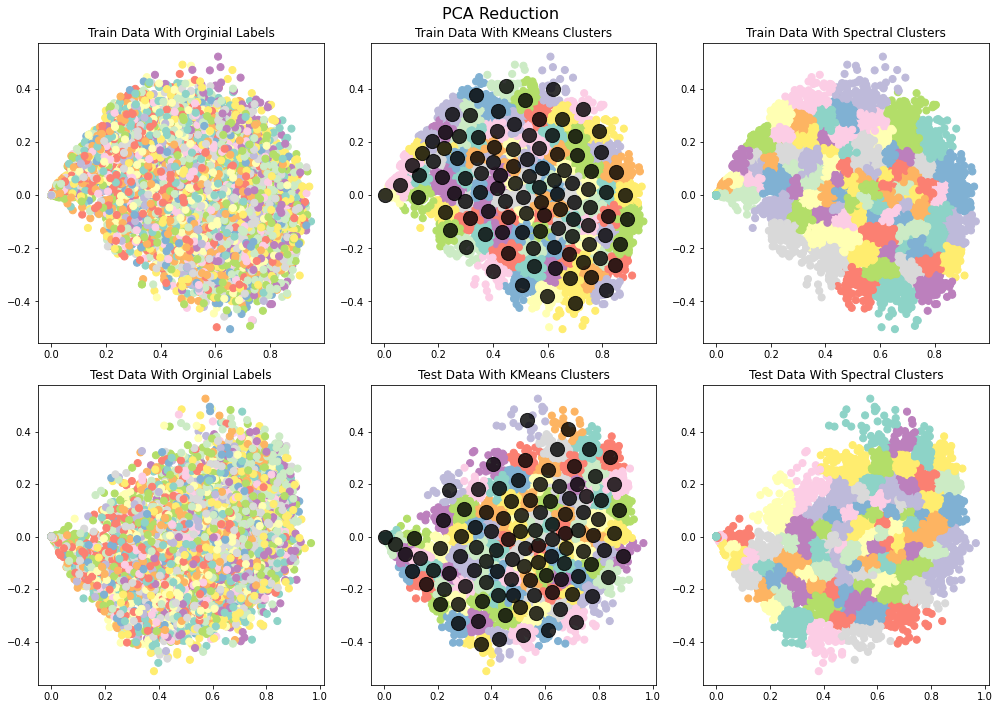

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


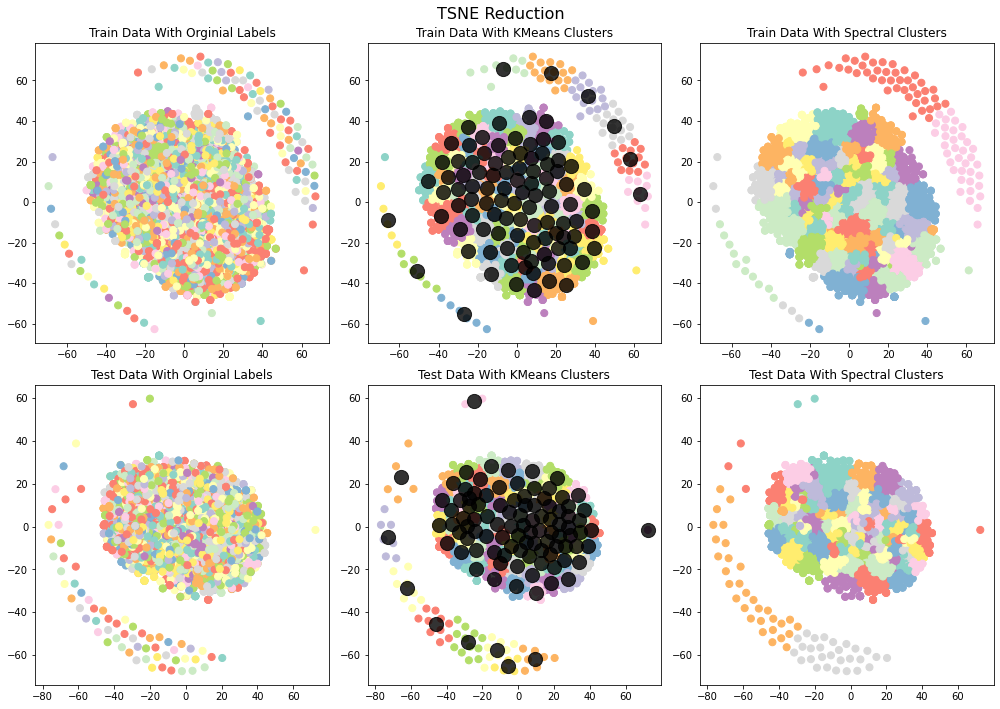

time: 1h 5s (started: 2021-01-08 01:27:58 +00:00)


In [ ]:
# rcv1 reduction
dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
visualize_pca(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
visualize_tsne(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103, True)